# 🖼️ Image Datasets and Transforms (PyTorch + TorchVision)

## 🎯 Objectives
- Build an **image dataset object** using the PyTorch `Dataset` protocol.
- Apply **pre-built transforms** from **TorchVision** using `transforms.Compose`.
- Compare a **CSV-backed custom dataset** with **TorchVision's FashionMNIST** using a **DataLoader**.


## Table of Contents
- [Preparation](#preparation)
- [Auxiliary Functions](#auxiliary)
- [Create a Dataset Class](#data_class)
- [TorchVision Transforms](#torchvision)
- [FashionMNIST + DataLoader](#fashionmnist)
- [Practice](#practice)
- [Summary](#summary)

## <a id="preparation"></a> 🔧 Preparation (Data Download Notes)

> The original lab downloads a tiny (100 samples) image set. In many environments, shell downloads are disabled; if yours allows it, use:

```bash
# (Optional) Download in an environment that supports shell commands
# wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/labs/Week1/data/img.tar.gz -P /resources/data
# tar -xf /resources/data/img.tar.gz 
# wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/labs/Week1/data/index.csv
```

This notebook assumes `index.csv` and images are present locally.


In [2]:
!mkdir -p ./resources/data


In [3]:
!curl -o ./resources/data/img.tar.gz https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/labs/Week1/data/img.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50460  100 50460    0     0  16369      0  0:00:03  0:00:03 --:--:-- 16372


In [4]:
!tar -xf ./resources/data/img.tar.gz -C ./resources/data/


In [5]:
!curl -o ./resources/data/index.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/labs/Week1/data/index.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1641k  100 1641k    0     0   427k      0  0:00:03  0:00:03 --:--:--  427k


## 📦 Imports

In [6]:
# ==========================================
# 📦 Importing Required Libraries
# ==========================================

# OS utilities → used to manage file paths, directories, and combine CSV + image paths safely
import os

# NumPy → used for numerical operations, though not heavily in this lab
# (useful for tensor ↔ numpy conversions and low-level math if needed)
import numpy as np

# Pandas → used to read and manage the CSV file (index.csv) containing image names and labels
# We'll access labels and filenames via .iloc[] from this DataFrame
import pandas as pd

# PyTorch core library → used for tensors, autograd, and the Dataset API
import torch

# ==========================================
# 🎨 Plotting and Visualization
# ==========================================
# Matplotlib is used to visualize images and labels in this lab
# Example: plt.imshow(image), plt.title(label)
import matplotlib.pyplot as plt

# imshow → convenience import for quick image display
from matplotlib.pyplot import imshow

# ==========================================
# 🧱 PyTorch Dataset API
# ==========================================
# Dataset → allows us to create custom datasets by subclassing it
# DataLoader → helps us iterate through datasets efficiently (batching, shuffling, etc.)
from torch.utils.data import Dataset, DataLoader

# ==========================================
# 🖼️ Image Handling
# ==========================================
# PIL (Python Imaging Library) → used to open, manipulate, and convert images
# Example: Image.open(img_path)
from PIL import Image

# ==========================================
# 🧩 TorchVision Utilities
# ==========================================
# transforms → provides prebuilt image transformations (cropping, flipping, normalization, etc.)
# Example: transforms.Compose([transforms.CenterCrop(20), transforms.ToTensor()])
import torchvision.transforms as transforms

# datasets → gives access to popular datasets like MNIST, CIFAR-10, and FashionMNIST
# We’ll use this to demonstrate pre-built datasets instead of custom CSV-based datasets
import torchvision.datasets as tv_datasets

# utils (vutils) → helper functions like make_grid() for visualizing multiple images together
# Example: vutils.make_grid(batch_images)
import torchvision.utils as vutils

# ==========================================
# 🧮 Reproducibility
# ==========================================
# Sets a fixed seed so random operations (like shuffling, transformations) give the same results each run
torch.manual_seed(0)

print("Libraries imported successfully.")


Libraries imported successfully.



---

## <a id="auxiliary"></a> 🧩 Auxiliary Functions & CSV Exploration

We’ll read `index.csv`, which should have **two columns**:

- column 0 → **label** (`int`)
- column 1 → **filename** (`str`) of the image

The number of rows equals the number of samples, $N$.


In [ ]:
directory = './resources/data'
# --- CSV path setup ---
file_name = 'index.csv' # CSV with columns [label, filename]

csv_path = os.path.join(directory, file_name)

In [ ]:
## Check if file exists 
if os.path.exists(csv_path):
    # --- Read CSV into a DataFrame ---
    data_name = pd.read_csv(csv_path)
    display(data_name.head())
else:
    print(f"⚠️ CSV not found at: {csv_path}. Some cells below will be skipped.")

,category,image
0,Ankle boot,img/fashion0.png
1,T-shirt,img/fashion1.png
2,T-shirt,img/fashion2.png
3,Dress,img/fashion3.png
4,T-shirt,img/fashion4.png


### Accessing values with `.iloc`

- `data_name.iloc[i, 0]` → label of sample `i`  
- `data_name.iloc[i, 1]` → filename of sample `i`  


In [9]:
if 'data_name' in globals() and len(data_name) >= 2:
    print(f"File Name (row: 0, column: 1) {data_name.iloc[0, 1]}")
    print(f"class or y (row: 0, columns: 0) {data_name.iloc[0, 0]}")
    print(f"File name (row: 1, column: 1) {data_name.iloc[1, 1]}")
    print(f"class or y (row: 1, column 0) {data_name.iloc[1, 0]}")
    print(f"The number of rows {data_name.shape}")
else:
    print('⚠️ Not enough rows to demo .iloc (or CSV missing).')

File Name (row: 0, column: 1) img/fashion0.png
class or y (row: 0, columns: 0) Ankle boot
File name (row: 1, column: 1) img/fashion1.png
class or y (row: 1, column 0) T-shirt
The number of rows (60000, 2)


## <a id="load_image"></a> 🖼️ Loading & Displaying Images

To load an image, concatenate `directory` and the filename from the DataFrame.


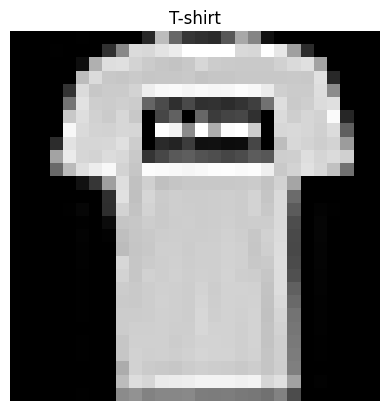

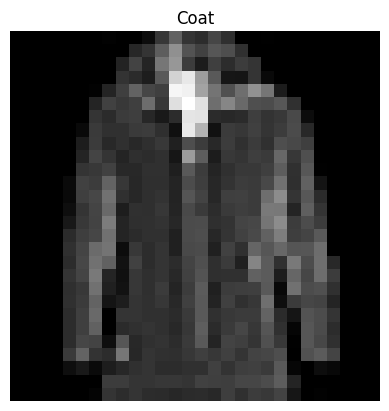

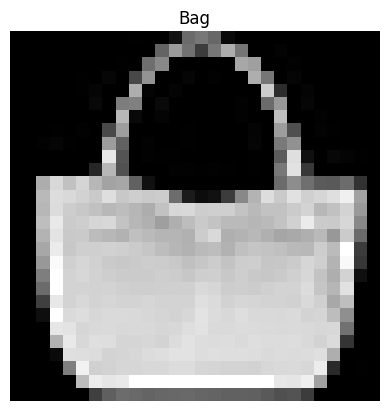

In [14]:
def show_image_row(row_index):
    """Display image at specific row_index from data_name, if available."""
    
    if 'data_name' in globals() and len(data_name) <= row_index:
        print(f'⚠️ Cannot show row {row_index}: CSV missing or too few rows.')
        return
    
    image_name = data_name.iloc[row_index, 1]
    image_path = os.path.join(directory, image_name)

    if not os.path.exists(image_path):
        print(f'⚠️ Image file not found: {image_path}')
        return
    
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.title(str(data_name.iloc[row_index, 0]))
    plt.axis('off')
    plt.show()


show_image_row(1)

show_image_row(19)

show_image_row(100)

### Helper to visualize dataset samples returned as `(tensor_image, label)`

In [42]:
def show_data(data_sample, shape=(28, 28)):
    """
    🖼️ Visualize a dataset sample (image + label)

    Args:
        data_sample (tuple): (image_tensor_or_array, label)
            - image_tensor_or_array → can be a NumPy array or PyTorch tensor
            - label → numeric or string class name

        shape (tuple): reshape target for 2D visualization
            - Only used if image is a 1D flattened array (e.g. 784 → 28x28)
    """

    # unpack sample tuple
    image, label = data_sample

    # --------------------------------------------------------
    # 🧠 CASE 1: Image is a PyTorch tensor with shape (C, H, W)
    # --------------------------------------------------------
    # Many torchvision datasets (e.g. MNIST, CIFAR) return images as:
    #   - 3D tensors → (Channels, Height, Width)
    #   - For grayscale: Channels = 1 → shape (1, 28, 28)
    # So we need to remove the single channel dimension before plotting.
    # --------------------------------------------------------

    if (isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[0] == 1):
         # .squeeze(0) removes dimension 0 if its size = 1
        # Example: (1, 28, 28) → (28, 28)

        # ----------------------------------------------------------
        # PyTorch tensors for grayscale images often have shape (C, H, W)
        #   - C: single color channel (grayscale)
        #   - H: height (e.g., 28)
        #   - W: width  (e.g., 28)
        #
        # Matplotlib expects a 2D array (H, W) to display grayscale images.
        # Therefore, we use .squeeze(0) to remove the first dimension (the '1' channel):
        #   Example:
        #     Original: (1, 28, 28)
        #     After squeeze(0): (28, 28)
        # ----------------------------------------------------------
        plt.imshow(image.squeeze(0).numpy(), cmap='gray')

    # --------------------------------------------------------
    # 🧠 CASE 2: Image is a NumPy array or already 2D
    # --------------------------------------------------------
    # Convert whatever it is into a NumPy array (safe for plotting)
    else:
        arr = np.array(image)
        # Some datasets store flattened images → shape (784,)
        # So we reshape it back into (28, 28)

        if arr.ndim == 1:
            arr = arr.reshape(shape)

        plt.imshow(arr, cmap='gray')

    # --------------------------------------------------------
    # Add title and formatting
    # --------------------------------------------------------

    plt.title(f"y: {str(label)}") # Show label as title
    plt.axis('off')
    plt.show()



---
## <a id="data_class"></a> 🧱 Create a Dataset Class (CSV-Backed)

We implement a **CSV-backed image dataset** using the PyTorch `Dataset` protocol:

- `__init__`: store paths, read CSV (do **not** load all images)
- `__len__`: return $N$
- `__getitem__`: open one image by index, apply optional transforms, return `(image, label)`

In [ ]:
class ImageCSVDataSet(Dataset):
    """CSV-backed image dataset.

    Expects a CSV with two columns:
        col 0 -> label (int)
        col 1 -> filename (str) relative to `data_dir`
    """

    def __init__(self, csv_file, directory = '', transform = None):
        # --- Save config ---
        self.directory = directory # Directory containing images
        self.transform = transform # Optional image transformer pipeline

        # --- Build absolute CSV path and read ---
        csv_abs = os.path.join(directory, csv_file) if self.directory else csv_file

        if not os.path.exists(csv_abs):
            raise FileNotFoundError(f'CSV file not found at the path: {csv_abs}')
        
        self.data_name = pd.read_csv(csv_abs)

        # --- Number of samples (rows of the CSV) ---
        self.len = self.data_name.shape[0]

    def __len__(self):
        """Return dataset size N (enables len(ds))."""
        return self.len
    
    def __getitem__(self, index):
        """Return one sample (image, label) at index `index`.

        Steps:
          1) Build path: data_dir / filename
          2) Open with PIL
          3) Apply transform if provided
          4) Return (image, label)
        """

        filename = self.data_name.iloc[index, 1]
        # 1) Build path to image file
        img_path = os.path.join(self.directory, filename) if self.directory else filename

        if not os.path.exists(img_path):
            raise FileNotFoundError(f'Image not found at the path: {img_path}')
        
        # 2) Open image (kept generic; if you know dataset is grayscale, you can .convert("L"))
        image = Image.open(img_path)

        # 3) Label
        y = str(self.data_name.iloc[index, 0])

         # 4) Apply transform pipeline (e.g., crop, ToTensor, normalize, etc.)
        if self.transform is not None:
            image = self.transform(image)
        
        return image, y
    
print('ImageCSVDataset ready.')

ImageCSVDataset ready.


### Instantiate & Visualize a Few Samples

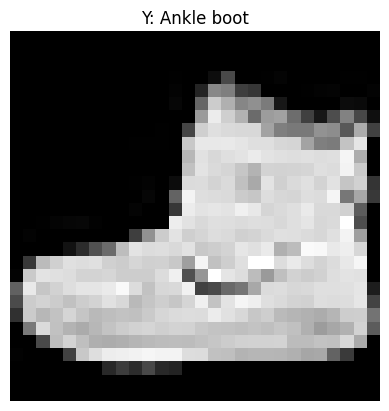

In [24]:
if os.path.exists(csv_path):
    image_data_Set = ImageCSVDataSet(csv_file=file_name, directory=directory, transform=None)

    # First sample (PIL image)
    img0, y0 = image_data_Set[0]

    plt.imshow(img0, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Y: {y0}')
    plt.axis('off')
    plt.show()

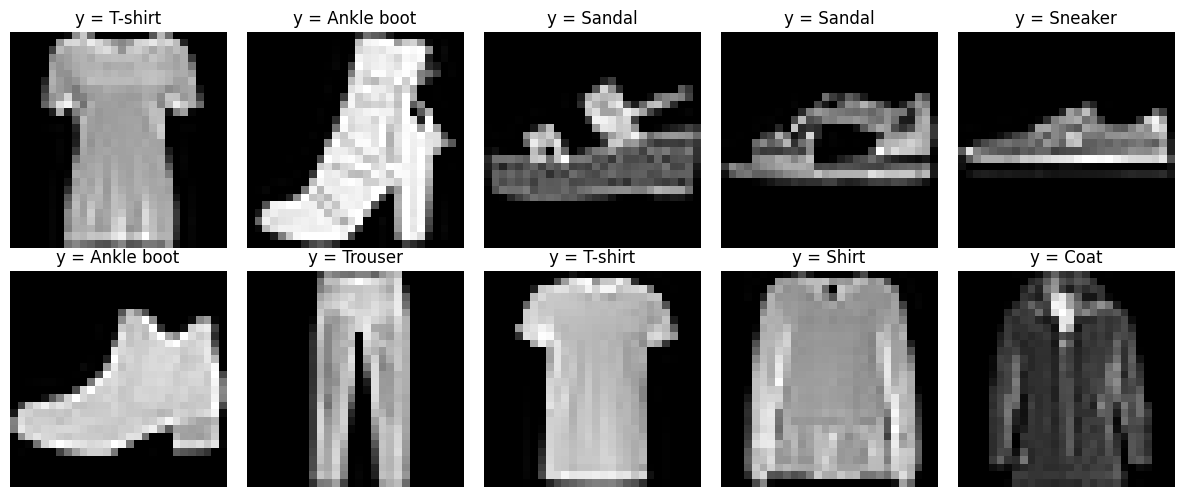

In [27]:
# Choose start and end indices
start_idx, end_idx = 10, 20

# Number of images
n_images = end_idx - start_idx

# Create a subplot grid (e.g., 2 rows × 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over the images
for i, idx in enumerate(range(start_idx, end_idx)):
    img, label = image_data_Set[idx]  # get image and label

    # Show image
    axes[i].imshow(img, cmap='gray', vmin=0, vmax=255)
    axes[i].set_title(f"y = {label}")
    axes[i].axis('off')

# Adjust layout for cleaner look
plt.tight_layout()
plt.show()



---
## <a id="torchvision"></a> 🧰 TorchVision Transforms

We commonly **compose** transforms with `transforms.Compose`:

- `transforms.CenterCrop(size)`  
- `transforms.ToTensor()` → converts PIL `[0,255]` to Tensor `[0,1]` with shape $(C,H,W)$  
- `transforms.RandomVerticalFlip(p)`  
- `transforms.RandomHorizontalFlip(p)`  


### ✂️ Crop + Tensor

We crop to **20×20** and convert to a tensor. For a grayscale image, the tensor shape becomes:

$$
(C, H, W) = (1, 20, 20)
$$


Shape of the data set torch.Size([1, 20, 20])


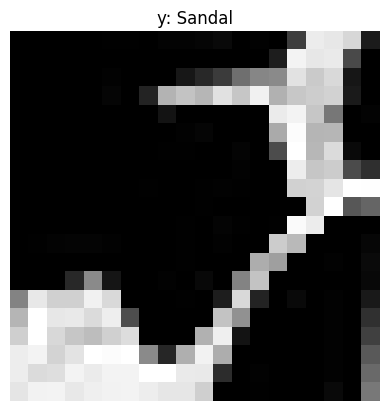

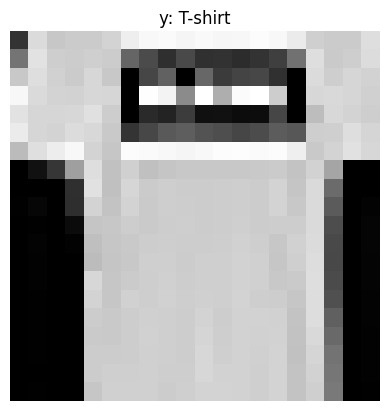

In [ ]:
croptensor_data_transform = transforms.Compose([
    transforms.CenterCrop(20),
    transforms.ToTensor()
])

csv_path = os.path.join(directory, file_name)
if os.path.exists(csv_path):
    image_data_set_crop = ImageCSVDataSet(csv_file=file_name, directory=directory, transform=croptensor_data_transform)
    print(f"Shape of the data set {image_data_set_crop[0][0].shape}")
    show_data(image_data_set_crop[0], shape=(20, 20))
    if len(image_data_set_crop) > 1:
        show_data(image_data_set_crop[1], shape=(20, 20))
else:
    print('⚠️ Skipping crop demo: CSV not found.')


---
## <a id="fashionmnist"></a> 👗 FashionMNIST + DataLoader

For standard datasets, prefer **TorchVision built-ins**.  
Here we demonstrate `FashionMNIST` (10 classes, 28×28 grayscale).

### Transform & Normalization

A typical transform chain for grayscale:
$$
\text{ToTensor} \;\Rightarrow\; \text{Normalize(mean=[0.5], std=[0.5])}
$$
which maps pixel values from $[0,1]$ to roughly $[-1, 1]$:
$$
x_{\text{norm}} = \frac{x - 0.5}{0.5}.
$$


Train size: 60000 | Test size: 10000
Batch images: torch.Size([64, 1, 28, 28]) Batch labels: torch.Size([64])


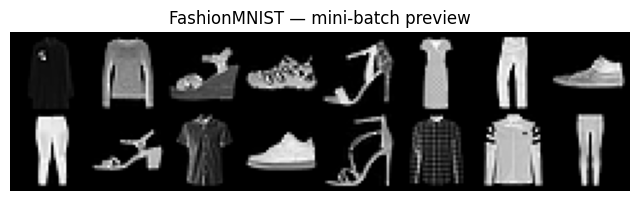

In [51]:
# Transform for FashionMNIST (grayscale)
fmnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # (C=1)
])

# Create datasets (will download if not found)
try:
    train_set = tv_datasets.FashionMNIST(root="data/", train=True, download=True, transform=fmnist_tf)
    test_set  = tv_datasets.FashionMNIST(root="data/", train=False, download=True, transform=fmnist_tf)

    print("Train size:", len(train_set), "| Test size:", len(test_set))

    # DataLoaders for batching and shuffling
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_set,  batch_size=64, shuffle=False, num_workers=2)

    # Inspect one mini-batch
    xb, yb = next(iter(train_loader))
    print("Batch images:", xb.shape, "Batch labels:", yb.shape)  # e.g., [64, 1, 28, 28], [64]

    # Visualize a grid of the first 16 images from the batch (unnormalized for display)
    grid = vutils.make_grid(xb[:16].detach().clone(), nrow=8, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(8,4))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title("FashionMNIST — mini-batch preview")
    plt.axis("off")
    plt.show()

except Exception as e:
    print("⚠️ FashionMNIST demo skipped due to:", e)